**Optimized Convolutional Neural Network for Pneumonia Classification in Chest X-ray Images Using Fine-Tuning and Data Augmentation**

*prageethm*

![](https://www.radiologymasterclass.co.uk/images/chest-images/gallery-pulmonary/compare_1.jpg?mtime=20210304211317&focal=none)


In [55]:
import numpy as np
import pandas as pd
import os
import random
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, GaussianNoise, Input, MultiHeadAttention, Reshape, GaussianNoise
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import InceptionV3
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, roc_curve, auc, accuracy_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.calibration import calibration_curve
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score


In [56]:
base_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray'
categories = {
    'NORMAL': 'NORMAL',
    'PNEUMONIA': 'PNEUMONIA',
}
file_paths = []
labels = []
for label, subfolder in categories.items():
    folder_path = os.path.join(base_dir, 'train', subfolder)
    for filename in os.listdir(folder_path):
        file_paths.append(os.path.join(folder_path, filename))
        labels.append(label)
df = pd.DataFrame({'file_path': file_paths, 'label': labels})

In [57]:
print("Sample DataFrame:")
print(df.head())

Sample DataFrame:
                                           file_path   label
0  /kaggle/input/chest-xray-pneumonia/chest_xray/...  NORMAL
1  /kaggle/input/chest-xray-pneumonia/chest_xray/...  NORMAL
2  /kaggle/input/chest-xray-pneumonia/chest_xray/...  NORMAL
3  /kaggle/input/chest-xray-pneumonia/chest_xray/...  NORMAL
4  /kaggle/input/chest-xray-pneumonia/chest_xray/...  NORMAL


In [ ]:
 for filename in os.listdir(folder_path):
        if filename.lower().endswith(('png', 'jpg', 'jpeg')):  # Ensure valid image files
            file_paths.append(os.path.join(folder_path, filename))
            labels.append(label)

# Display the categorized file paths and labels
for path, label in zip(file_paths, labels):
    print(f"File: {path} | Label: {label}")

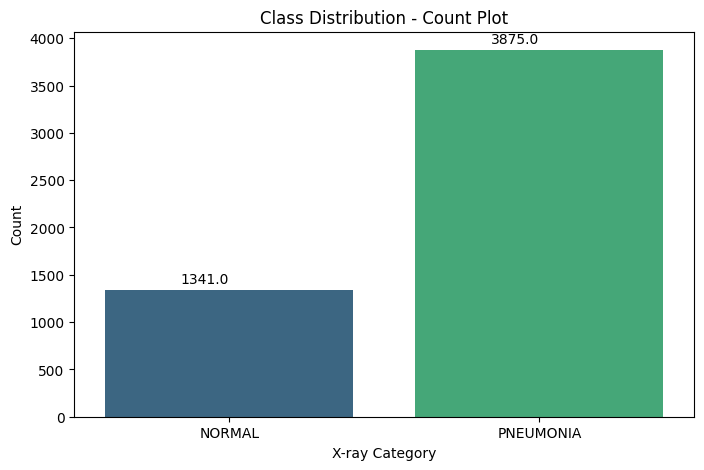

In [59]:
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='label', data=df, palette='viridis')
plt.title('Class Distribution - Count Plot')
plt.xlabel('X-ray Category')
plt.ylabel('Count')
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2.5, p.get_height()),
                ha='center', va='center', xytext=(0, 7.5), textcoords='offset points')
plt.show()

In [60]:
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(df[['file_path']], df['label'])
df_resampled = pd.DataFrame(X_resampled, columns=['file_path'])
df_resampled['label'] = y_resampled

In [61]:
le = LabelEncoder()
df_resampled['label_encoded'] = le.fit_transform(df_resampled['label'])

In [62]:
batch_size = 16
img_size = (224, 224)

train_gen = ImageDataGenerator(rescale=1./255)
valid_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

In [63]:
train_df, temp_df = train_test_split(df_resampled, train_size=0.8, shuffle=True, random_state=42, stratify=df_resampled['label_encoded'])
valid_df, test_df = train_test_split(temp_df, test_size=0.5, shuffle=True, random_state=42, stratify=temp_df['label_encoded'])

In [64]:
train_df['label_encoded'] = train_df['label_encoded'].astype(str)
valid_df['label_encoded'] = valid_df['label_encoded'].astype(str)
test_df['label_encoded'] = test_df['label_encoded'].astype(str)

In [65]:
train_gen_new = train_gen.flow_from_dataframe(
    train_df,
    x_col='file_path',
    y_col='label_encoded',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=32
)

Found 6200 validated image filenames belonging to 2 classes.


In [66]:
valid_gen_new = valid_gen.flow_from_dataframe(
    valid_df,
    x_col='file_path',
    y_col='label_encoded',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=32
)

Found 775 validated image filenames belonging to 2 classes.


In [67]:
test_gen_new = test_gen.flow_from_dataframe(
    test_df,
    x_col='file_path',
    y_col='label_encoded',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

Found 775 validated image filenames belonging to 2 classes.


In [68]:
def create_inceptionv3_model(input_shape):
    inputs = Input(shape=input_shape)
    base_model = InceptionV3(weights='imagenet', input_tensor=inputs, include_top=False)
    for layer in base_model.layers:
        layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = GaussianNoise(0.1)(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(2, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

input_shape = (224, 224, 3)
model = create_inceptionv3_model(input_shape)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [72]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_gen_new,
    validation_data=valid_gen_new,
    epochs=10,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 75s 375ms/step - accuracy: 0.9675 - loss: 0.0852 - val_accuracy: 0.9755 - val_loss: 0.0828
Epoch 2/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 75s 374ms/step - accuracy: 0.9663 - loss: 0.0861 - val_accuracy: 0.9652 - val_loss: 0.1078
Epoch 3/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 76s 377ms/step - accuracy: 0.9723 - loss: 0.0801 - val_accuracy: 0.9639 - val_loss: 0.1111
Epoch 4/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 76s 376ms/step - accuracy: 0.9638 - loss: 0.0924 - val_accuracy: 0.9819 - val_loss: 0.0582
Epoch 5/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 74s 369ms/step - accuracy: 0.9696 - loss: 0.0803 - val_accuracy: 0.9819 - val_loss: 0.0612
Epoch 6/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 74s 370ms/step - accuracy: 0.9737 - loss: 0.0727 - val_accuracy: 0.9613 - val_loss: 0.1178
Epoch 7/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 74s 369ms/step - accuracy: 0.9672 - loss: 0.0802 - val_accuracy: 0.9742 - val_loss: 0.0732
Epoch 8/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 75s 373ms/step - accuracy: 0.9677 - loss: 0

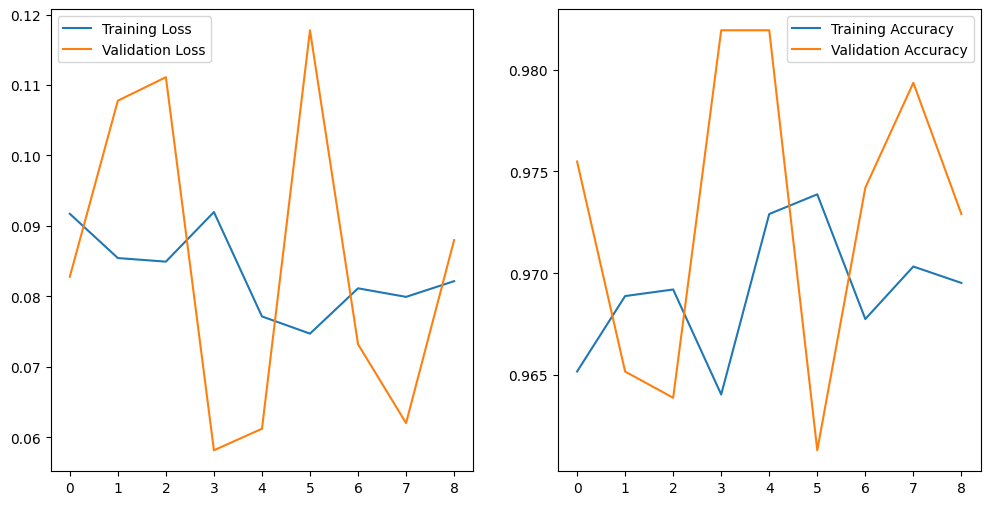

In [73]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

In [74]:
for layer in model.layers[-20:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
fine_tune_history = model.fit(
    train_gen_new,
    validation_data=valid_gen_new,
    epochs=5,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/5
194/194 ━━━━━━━━━━━━━━━━━━━━ 99s 430ms/step - accuracy: 0.9632 - loss: 0.1104 - val_accuracy: 0.9677 - val_loss: 0.0845
Epoch 2/5
194/194 ━━━━━━━━━━━━━━━━━━━━ 76s 379ms/step - accuracy: 0.9794 - loss: 0.0578 - val_accuracy: 0.9716 - val_loss: 0.0711
Epoch 3/5
194/194 ━━━━━━━━━━━━━━━━━━━━ 76s 380ms/step - accuracy: 0.9850 - loss: 0.0458 - val_accuracy: 0.9535 - val_loss: 0.1342
Epoch 4/5
194/194 ━━━━━━━━━━━━━━━━━━━━ 74s 368ms/step - accuracy: 0.9909 - loss: 0.0304 - val_accuracy: 0.9871 - val_loss: 0.0316
Epoch 5/5
194/194 ━━━━━━━━━━━━━━━━━━━━ 75s 372ms/step - accuracy: 0.9892 - loss: 0.0315 - val_accuracy: 0.9716 - val_loss: 0.0973


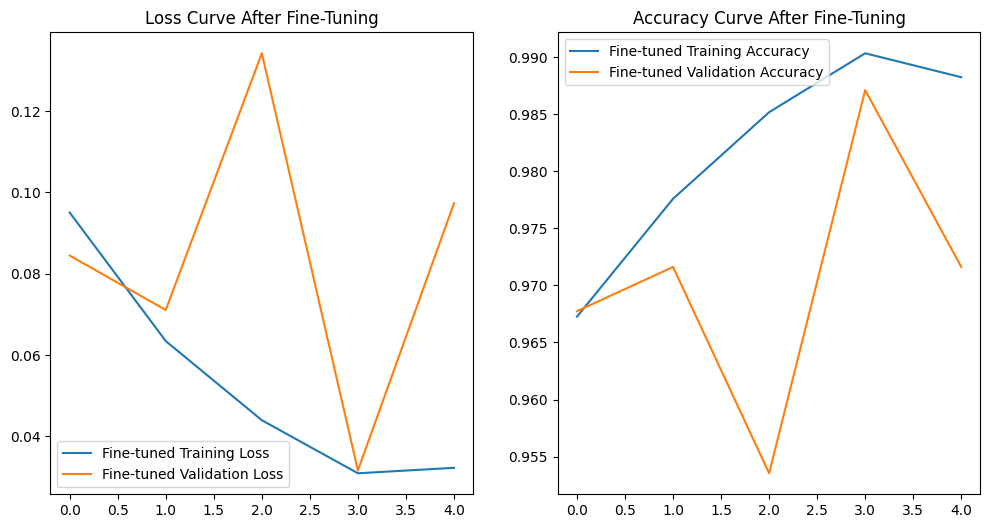

In [75]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(fine_tune_history.history['loss'], label='Fine-tuned Training Loss')
plt.plot(fine_tune_history.history['val_loss'], label='Fine-tuned Validation Loss')
plt.legend()
plt.title('Loss Curve After Fine-Tuning')

plt.subplot(1, 2, 2)
plt.plot(fine_tune_history.history['accuracy'], label='Fine-tuned Training Accuracy')
plt.plot(fine_tune_history.history['val_accuracy'], label='Fine-tuned Validation Accuracy')
plt.legend()
plt.title('Accuracy Curve After Fine-Tuning')
plt.show()

49/49 ━━━━━━━━━━━━━━━━━━━━ 16s 248ms/step


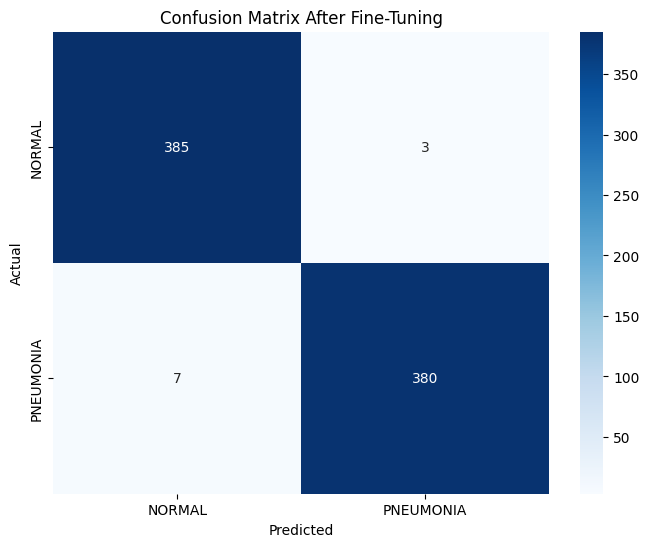

In [76]:
y_true = test_gen_new.labels
y_pred_fine = model.predict(test_gen_new)
y_pred_classes_fine = np.argmax(y_pred_fine, axis=1)

cm_fine = confusion_matrix(y_true, y_pred_classes_fine)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_fine, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix After Fine-Tuning')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [79]:
report = classification_report(y_true, y_pred_classes_fine, target_names=le.classes_)
print("Classification Report:\n")
print(report)

Classification Report:

              precision    recall  f1-score   support

      NORMAL       0.98      0.99      0.99       388
   PNEUMONIA       0.99      0.98      0.99       387

    accuracy                           0.99       775
   macro avg       0.99      0.99      0.99       775
weighted avg       0.99      0.99      0.99       775



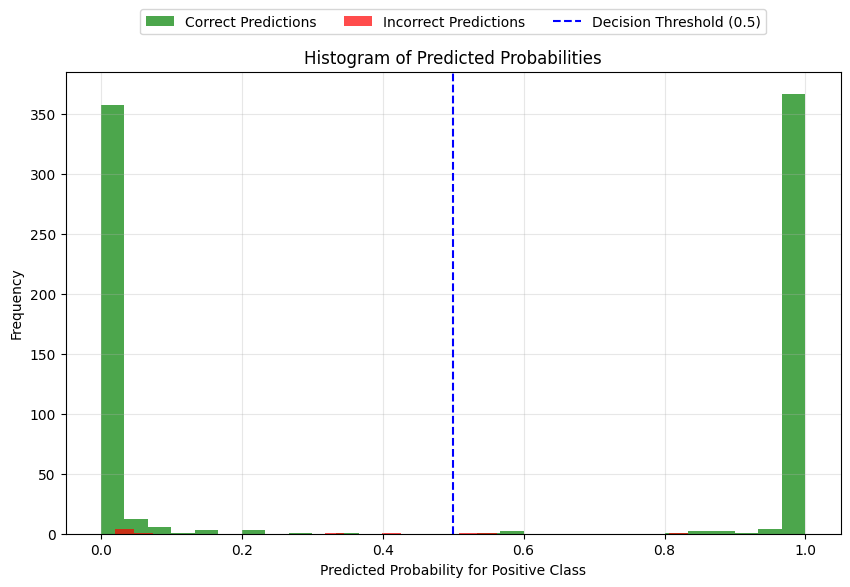

In [80]:
correct_predictions = (y_true == y_pred_classes_fine)
incorrect_predictions = ~correct_predictions
correct_probs = y_pred_fine[correct_predictions, 1]  
incorrect_probs = y_pred_fine[incorrect_predictions, 1]
plt.figure(figsize=(10, 6))
plt.hist(correct_probs, bins=30, alpha=0.7, color='green', label='Correct Predictions')
plt.hist(incorrect_probs, bins=30, alpha=0.7, color='red', label='Incorrect Predictions')
plt.axvline(0.5, color='blue', linestyle='--', label='Decision Threshold (0.5)', linewidth=1.5)
plt.title('Histogram of Predicted Probabilities')
plt.xlabel('Predicted Probability for Positive Class')
plt.ylabel('Frequency')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4)
plt.grid(alpha=0.3)
plt.show()

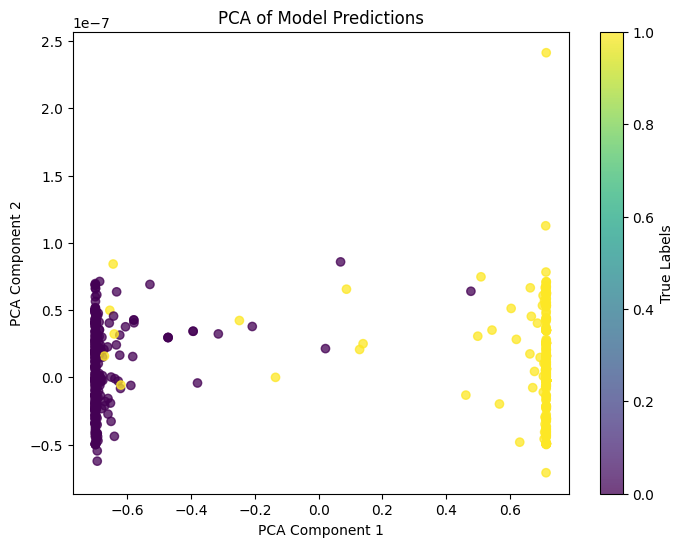

In [81]:
pca = PCA(n_components=2)
features_pca = pca.fit_transform(y_pred_fine)
plt.figure(figsize=(8, 6))
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=y_true, cmap='viridis', alpha=0.75)
plt.colorbar(label='True Labels')
plt.title('PCA of Model Predictions')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()